In [1]:
!pip install mtcnn==0.1.1 -q

# <span style="color:#2C3E50; font-size:28px; font-weight:bold;">Face Verification Using FaceNet and MTCNN</span>

## <span style="color:#2980B9; font-size:24px; font-weight:bold;">Objective</span>
The purpose of this notebook is to demonstrate a face verification system using a pre-trained **FaceNet** model to verify the identity of a target individual (**Bill Gates**) in images containing multiple faces.

## <span style="color:#2980B9; font-size:24px; font-weight:bold;">Dataset</span>
We are using a public dataset containing images of celebrities. The goal is to extract face embeddings for the selected individual (**Bill Gates**) and verify their presence in images with multiple people.

## <span style="color:#2980B9; font-size:24px; font-weight:bold;">Solution Approach</span>

1. **Data Preparation**  
   - Selected **Bill Gates** as the target individual for verification.  
   - Chose **10 images** of Bill Gates from the dataset.  
   - Resized each image to **160x160** pixels for FaceNet compatibility.  

2. **Embedding Creation**  
   - Used a pre-trained **FaceNet model** to extract **128-dimensional face embeddings** for each of the 10 images of Bill Gates.
   - Computed the **average** of these embeddings to create a reference vector representing Bill Gates.

3. **Testing on Crowd Images**  
   - Input crowd images that potentially include Bill Gates.  
   - Used the **MTCNN** (Multi-task Cascaded Convolutional Networks) to detect faces within the crowd.  
   - Each detected face was resized to **160x160** pixels and converted into a **128-dimensional embedding** using the same FaceNet model.

4. **Distance Calculation**  
   - Calculated the **L2 norm** of the distance between the average embedding of Bill Gates and each detected face in the crowd.  
   - If the distance is **within 1.00**, the detected face is considered a **true positive** (Bill Gates); otherwise, it is ignored.

---

**Note:** This approach focuses on finding Bill Gates in crowd images, but it can be generalized to other individuals by updating the target face embeddings.



# Imports

In [2]:
# Common
import time
import os
import csv
import numpy as np

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image

# Ai Model
import tensorflow as tf
from mtcnn.mtcnn import MTCNN

# For multithreading
from concurrent.futures import ThreadPoolExecutor

# Other
from IPython.display import clear_output as cls

# Constants

In [3]:
MODEL_PATH = '/kaggle/input/facenet-tensorflow/tensorflow2/default/2/'

BILL_GATES_IMGS_PATH = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Bill Gates/'
BEN_AFFLECK_IMGS_PATH = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Ben Affleck/'
ANNE_HATHAWAY_IMGS_PATH = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Anne Hathaway/'

BILL_GATES_IMGS_IN_CROWDS = '/kaggle/input/bill-gates-images/bill_gates/images/'

# Data Model

In [4]:
class DetectedFaces:
    def __init__(self, image, verified_faces, total_faces):
        self.image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        self.verified_faces = verified_faces
        self.total_faces = total_faces

class FaceData:
    def __init__(self, x, y, width, height, distance):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.distance = distance

# Utils

In [5]:
def get_image_paths(directory, valid_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".gif")):
    image_paths = []
    
    # Iterate over all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if file is an image based on its extension
            if file.lower().endswith(valid_extensions):
                # Append the full path of the image file to the list
                image_paths.append(os.path.join(root, file))
    
    return image_paths


def save_face_embeddings(embedding):
    # Ensure the embedding is a numpy array
    embedding = np.array(embedding)

    # Save to CSV
    with open('avg_face_embeddings.csv', mode="w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(embedding)


def plt_img(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()
    

def preprocess_img(image):
    """
    Preprocess Image:
    
    Args:
        image: np.ndarray
    
    Returns:
        4D(batch_size, height, width, channels)
            'batch_size': This is the number of images (or samples) processed together in one pass through the model.
            'height': The height of each image in pixels.
            'width': The width of each image in pixels.
            'channels': The number of color channels in each image.
    """
    # Dimensions
    IMG_W = 160
    IMG_H = 160
    
    # Resize the image
    image = cv2.resize(image, dsize = (IMG_W, IMG_H))
    
    # Convert image stype or normalize
    image = image.astype(np.float32)/255.0
    
    return image


def image_to_embedding(image: np.ndarray, model_infer):
    """Generate face embedding from an image."""
    
    # Increase image dim
    image_input = image[np.newaxis,...] # (1, 160, 160, 3)
    
    # Perform inference using the callable function
    result = model_infer(tf.convert_to_tensor(image_input, dtype=tf.float32))
    
    # Extract result from output key (1,128)
    embedding = result['Bottleneck_BatchNorm'].numpy()
    
    # Normalize bedding using L2 norm.
    embedding /= np.linalg.norm(embedding, ord=2)
    
    return embedding


def cal_embeddings_dist(embedding_1: np.ndarray, embedding_2: np.ndarray) -> float:
    """
    Compares two embeddings and returns L2 norm of the distance vector.

    Args:
    - embedding_1: A 128-dimensional embedding vector.
    - embedding_2: A 128-dimensional embedding vector.

    Returns:
    - L2 norm of the distance vector
    """

    # Calculate the distance between the embeddings
    embedding_distance = embedding_1 - embedding_2

    # Calculate the L2 norm of the distance vector
    embedding_distance_norm = np.linalg.norm(embedding_distance)
    
    return embedding_distance_norm


def plot_image_grid(images, images_per_row=5, total_images=50):
    # Ensure we don't exceed the available images or the limit of 50
    total_images = min(total_images, len(images))
    
    # Calculate the number of rows needed
    num_rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    # Flatten the axes array in case of more than one row
    axs = axs.ravel()

    for i in range(total_images):
        # Read and display the image
        img = images[i]
        axs[i].imshow(img)
        axs[i].axis('off')  # Turn off the axis for clean presentation

    # Turn off any remaining unused subplots (if total_images < images_per_row * num_rows)
    for j in range(total_images, len(axs)):
        axs[j].axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()
    

def plt_embeddings(embedding):
    # Normalized embedding
    embedding_normalized = (embedding - np.min(embedding)) / (np.max(embedding) - np.min(embedding))
    
    # Plt barcode
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(embedding_normalized)), embedding_normalized)
    plt.show()

# Step1: Read & Visualize Training Images

In [6]:
# Read all images
image_paths = get_image_paths(BILL_GATES_IMGS_PATH)

# Total samples
len(image_paths)

122

#### Pick 10 samples for training and pre-process them

In [7]:
training_images = []

# Slice 10 images for training
for idx in range(0, 11):
    # Read image
    image = plt.imread(image_paths[idx])

    # Preprocess image to normalize them into (160,160)
    preprocessed_img = preprocess_img(image)
    
    # Append preprocessed image
    training_images.append(preprocessed_img)

#### Visualize training samples

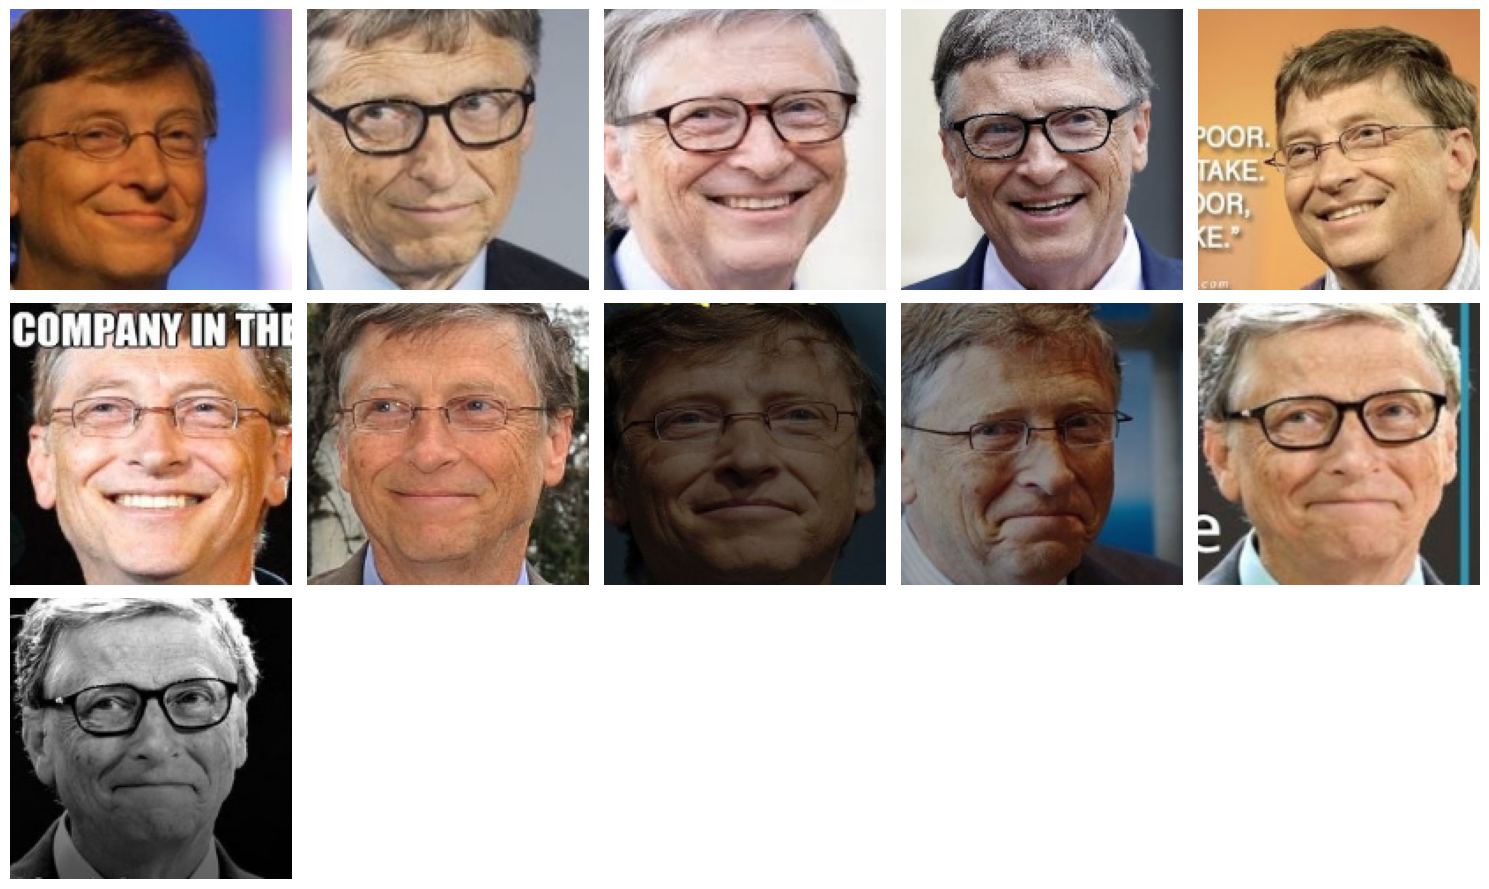

In [8]:
plot_image_grid(training_images)

# Step2: Load Pre-trained FaceNet Model & Generate Embeddings

In [9]:
# Load the model
model = tf.saved_model.load(MODEL_PATH)

# Get the callable function from the loaded model
infer = model.signatures['serving_default']

In [10]:
# Store embeddings
embeddings = np.empty(shape=(len(training_images[:10]), 128))

# Generate embeddings
for index, training_img in enumerate(training_images[:10]):
    # Generate embeddings
    embedding = image_to_embedding(training_img, infer)
    
    # Store embeddings
    embeddings[index] = embedding

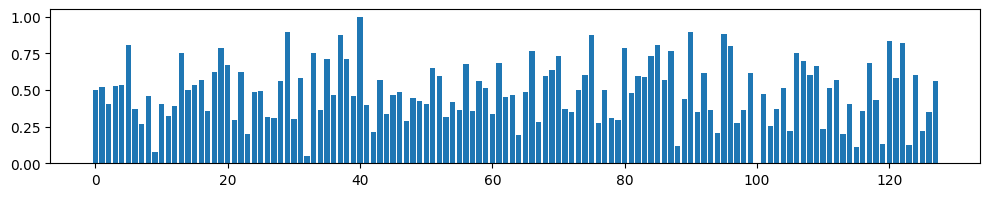

In [11]:
    plt_embeddings(embeddings[0])

# Step3: Average Generated Embeddings

In [12]:
# Compute average embedding
avg_embedding = np.mean(embeddings, axis=0)

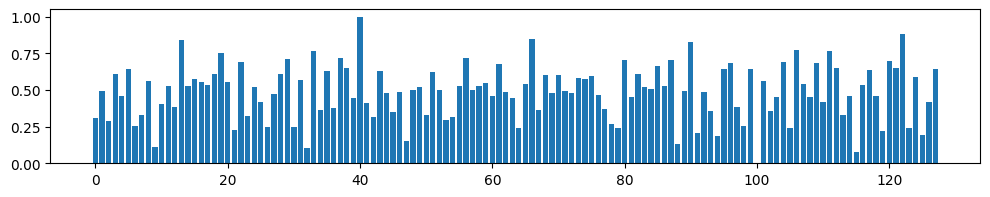

In [13]:
plt_embeddings(avg_embedding)

# Step4: Embedding Evaluation Over Positive Samples (Bill Gates)

Similarity Distance: 0.8476371084743946


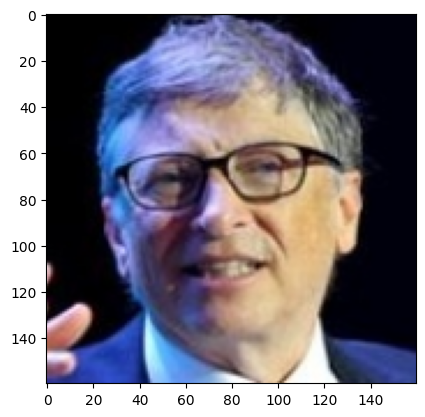

In [14]:
# Read a test sample
test_img = plt.imread('/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Bill Gates/Bill Gates122_510.jpg')

# Preprocess image to normalize them into (160,160)
preprocessed_test_img = preprocess_img(test_img)

# Extract face embedding
test_img_embedding = image_to_embedding(preprocessed_test_img, infer)

# Calculate distance between
dist = cal_embeddings_dist(avg_embedding, test_img_embedding)
print(f"Similarity Distance: {dist}")

# Plot Test Image
plt_img(preprocessed_test_img)

Similarity Distance: 0.6152799438668416


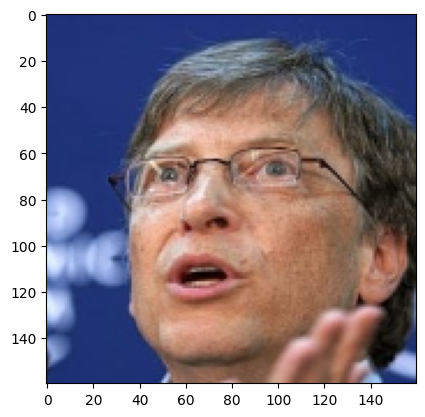

In [15]:
# Read a test sample
test_img = plt.imread('/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Bill Gates/Bill Gates127_514.jpg')

# Preprocess image to normalize them into (160,160)
preprocessed_test_img = preprocess_img(test_img)

# Extract face embedding
test_img_embedding = image_to_embedding(preprocessed_test_img, infer)

# Calculate distance between
dist = cal_embeddings_dist(avg_embedding, test_img_embedding)
print(f"Similarity Distance: {dist}")

# Plot Test Image
plt_img(preprocessed_test_img)

# Step5: Embedding Evaluation Over Negative Samples

In [ ]:
test_class_1_img_paths = get_image_paths(BEN_AFFLECK_IMGS_PATH) 
test_class_2_img_paths = get_image_paths(ANNE_HATHAWAY_IMGS_PATH)

In [ ]:
# Read a test sample
test_img = plt.imread(test_class_1_img_paths[2])

# Preprocess image to normalize them into (160,160)
preprocessed_test_img = preprocess_img(test_img)

# Extract face embedding
test_img_embedding = image_to_embedding(preprocessed_test_img, infer)

# Calculate distance between
dist = cal_embeddings_dist(avg_embedding, test_img_embedding)
print(f"Similarity Distance: {dist}")

# Plot Test Image
plt_img(preprocessed_test_img)

In [ ]:
# Read a test sample
test_img = plt.imread(test_class_2_img_paths[2])

# Preprocess image to normalize them into (160,160)
preprocessed_test_img = preprocess_img(test_img)

# Extract face embedding
test_img_embedding = image_to_embedding(preprocessed_test_img, infer)

# Calculate distance between
dist = cal_embeddings_dist(avg_embedding, test_img_embedding)
print(f"Similarity Distance: {dist}")

# Plot Test Image
plt_img(preprocessed_test_img)

It is being observed that the similarity distance score over same person is within **1.00**. We can use this for the person verification.

# Step6: Embedding Evaluation Over Positive Samples (Bill Gates) when in Crowd

In [ ]:
bill_gates_in_crowds_img_paths = get_image_paths(BILL_GATES_IMGS_IN_CROWDS) 

In [ ]:
# Read a test sample
test_img = plt.imread(bill_gates_in_crowds_img_paths[0])
plt_img(test_img)

## <span style="color:#2980B9; font-size:24px; font-weight:bold;">Using MTCNN for Face Detection</span>

<span style="color:#2C3E50; font-size:16px;">
<strong>MTCNN (Multi-task Cascaded Convolutional Networks)</strong> is widely regarded as one of the most effective models for face detection, particularly in crowded environments. It excels in handling faces at different scales and under challenging conditions like occlusions. Compared to older methods like the Haar classifier, MTCNN is more accurate and reliable for real-time face detection.
</span>

### <span style="color:#2980B9; font-size:20px;">Why MTCNN?</span>

- <strong>Robustness:</strong> MTCNN effectively detects faces of varying sizes, angles, and in cases where parts of the face might be occluded.
- <strong>Accuracy:</strong> It uses three stages of convolutional networks to accurately locate and crop faces from images.
- <strong>Versatility:</strong> MTCNN adapts well to images with multiple faces, making it ideal for crowded scenes.

### <span style="color:#2980B9; font-size:20px;">SSD Model (Single Shot Detector)</span>

<span style="color:#2C3E50; font-size:16px;">
The <strong>SSD (Single Shot Detector)</strong> model is another popular object detection model. Unlike MTCNN, SSD focuses on detecting multiple objects in an image using a single network. It divides the image into a grid and detects objects within each grid cell in a single forward pass. Although <strong>SSD</strong> is faster, it may struggle with small objects and occlusions, making it less ideal for detecting faces in crowded images compared to MTCNN.
</span>


In [ ]:
'''
min_face_size=40
MTCNN works by creating image pyramids at multiple scales to detect faces of various sizes. 
Reducing the number of scales (or setting specific min/max sizes) can save time:

steps_threshold = [0.6, 0.7, 0.7] or [0.7, 0.8, 0.8]
MTCNN uses three networks (P-Net, R-Net, O-Net) with different thresholds. 
You can modify the thresholds to skip detections that are not highly confident, 
thus reducing computational overhead
'''

# Initialize the MTCNN face detector
face_detector = MTCNN(min_face_size=40, steps_threshold=[0.7, 0.8, 0.8])

In [ ]:
detected_faces = []

for img_path in bill_gates_in_crowds_img_paths:
    result = detect_person_of_interest(
        img_path=img_path,
        face_detector=face_detector,
        infer=infer
    )
    detected_faces.append(result)

In [ ]:
def process_face(face, image, infer):
    x, y, width, height = face['box']
    trimmed_face = cv2.cvtColor(image[y:y+height, x:x+width], cv2.COLOR_BGR2RGB)
    preprocessed_test_img = preprocess_img(trimmed_face)
    test_img_embedding = image_to_embedding(preprocessed_test_img, infer)
    dist = cal_embeddings_dist(avg_embedding, test_img_embedding)
    return FaceData(x, y, width, height, dist)

def detect_person_of_interest(img_path, face_detector, infer):
    # Start timing for the whole function
    total_start_time = time.time()

    # Load the image
    load_img_start = time.time()
    original_image = cv2.imread(img_path)
    load_img_end = time.time()

    rgb_conv_start = time.time()
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    rgb_conv_end = time.time()

    # Detect faces in the image
    face_detect_start = time.time()
    faces = face_detector.detect_faces(rgb_image)
    face_detect_end = time.time()

    # Parallel face processing
    face_processing_start = time.time()
    with ThreadPoolExecutor() as executor:
        face_data = list(executor.map(lambda face: process_face(face, rgb_image, infer), faces))
    face_processing_end = time.time()

    # Sort image face_data based on the 'dist' attribute in ascending order
    sort_start = time.time()
    face_data.sort(key=lambda face: face.distance)
    sort_end = time.time()

    total_end_time = time.time()

    # Print out benchmark times
    print(f"Total Execution Time: {total_end_time - total_start_time:.4f} seconds")
    print(f"Image Loading Time: {load_img_end - load_img_start:.4f} seconds")
    print(f"RGB Conversion Time: {rgb_conv_end - rgb_conv_start:.4f} seconds")
    print(f"Face Detection Time: {face_detect_end - face_detect_start:.4f} seconds")
    print(f"Face Processing Time: {face_processing_end - face_processing_start:.4f} seconds")
    print(f"Sorting Time: {sort_end - sort_start:.4f} seconds")

    return DetectedFaces(image=original_image, verified_faces=face_data, total_faces=len(faces))

#### Visualize verified bill gates found in crowd

In [ ]:
for model in detected_faces:
    for face in model.verified_faces[:1]:
        if face.distance < 1.0:
            # Draw bounding box
            img = cv2.rectangle(model.image,
                                (face.x, face.y),
                                (face.x+face.width, face.y+face.height), 
                                (0, 255, 0), 2)

            # Add Distance Label
            label = f"{face.distance}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            color = (0, 255, 0)
            thickness = 2  # Text thickness
            cv2.putText(img, label,(face.x, face.y - 10), font, font_scale, color, thickness)

    # Plot the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title(f"Total detected faces: {model.total_faces}")
    plt.show()

## <span style="color:#2980B9; font-size:24px; font-weight:bold;">Conclusion</span>

<span style="color:#2C3E50; font-size:16px;">
In this notebook, we successfully implemented a face verification system using the <strong>MTCNN</strong> for face detection and the <strong>FaceNet</strong> pre-trained model for generating facial embeddings. We utilized a public dataset of celebrity faces, selecting Bill Gates as the target individual. By averaging embeddings from multiple images of Bill Gates, we created a robust template for face verification.

Through this approach, we demonstrated how <strong>L2 norm distance</strong> can effectively measure similarity between detected faces and the target individual. We also explored optimization techniques to improve the model’s performance, ensuring a balance between speed and accuracy. This workflow showcases how advanced facial recognition methods can be applied to real-world scenarios, such as crowd face verification.

Future work can focus on further optimizing the system for real-time applications by leveraging GPU acceleration or using alternative face detection models like **YOLO** or **SSD** for faster performance.
</span>

## <span style="color:#2980B9; font-size:24px; font-weight:bold;">Glossary</span>

- **FaceNet**: A deep learning model designed for face recognition and clustering by mapping facial images to a compact Euclidean space of embeddings.

- **L2 Norm**: A measure of distance between two points in a multi-dimensional space, calculated as the square root of the sum of the squared differences of their coordinates.

- **MTCNN (Multi-task Cascaded Convolutional Networks)**: A face detection framework that utilizes a cascaded structure to detect faces at different scales and handle occlusions effectively.

- **Embeddings**: A low-dimensional representation of high-dimensional data, such as images or words, that captures semantic relationships and features.
